In [1]:
from RFIx.observation import Observation

In [2]:
from RFIx.utils.plotting import histFit, plotNorm, jointHistFit, plotMultiNorm, correlations, gelmanRubin, ESS
from RFIx.utils.diagnostics import auto_correlation, split_chain, GR, effective_sample_size
from RFIx.utils.coordinates import radec_to_lm, ENU_to_GPS_el, GPS_to_XYZ, ENU_to_ITRF, ITRF_to_UVW, ENU_to_UVW, orbit, dist_centre
from RFIx.utils.interferometry import rfi_vis, im_to_vis, ants_to_bl
from RFIx.utils.mcmc import HMC
from RFIx.utils.mcmc import log_normal, log_multinorm
from jax import grad, jit, vmap, random, jacfwd, jacrev, partial

from jax.scipy.linalg import block_diag
from matplotlib.patches import Circle
from matplotlib import pyplot as plt
from scipy.stats import norm
import seaborn as sns
from tqdm import tqdm
import jax.numpy as jnp
import time

In [3]:
key = random.PRNGKey(0)

In [4]:
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
c = ChainConsumer()

In [6]:
plt.rcParams['font.size'] = 14

In [7]:
ENU = np.loadtxt('data/Meerkat.enu.txt')[0:64:8]

In [8]:
obs1 = Observation(latitude=-30., longitude=21., elevation=1050., ra=21., dec=-30., 
                  times=8.*np.arange(2), freqs=np.array([1e9]), ENU_array=ENU)

obs1.addAstro(I=np.ones((1,1)), ra=[21.0,], dec=[-30.0,])

obs1.addSat(I=10*np.ones((1,1)), elevation=35786e3, t0=0., theta0=0., phi0=0.)

obs1.addGains(G0_mean=3.0, G0_std=0., Gt_mean=0., Gt_std=0.)

obs1.addNoise(noise=0.2)

In [9]:
# Initialize parameters for HMC
qi1 = jnp.concatenate([obs1.rfi_I[:,0], obs1.rfi_elevation, obs1.rfi_theta0, obs1.rfi_phi0, 
                      obs1.rfi_t0, obs1.gains_ants[0,:,0]])

In [10]:
params1 = {}
params1['freqs'] = obs1.freqs
params1['times'] = obs1.times
params1['noise'] = 0.2 # obs.noise
params1['ants_xyz'] = obs1.ants_xyz
params1['phase_corrections'] = obs1.ants_uvw[:,:,-1]
params1['V_ast'] = obs1.vis_ast[:,:,0]
params1['D'] = np.concatenate([obs1.vis[i,:,0] for i in range(len(obs1.times))])
params1['tempering'] = 1e0

In [11]:
@jit
def log_prior1(q, params):
    return 0.0

@jit
def log_likelihood1(q, params):
#      THETA
    A, el, theta0, phi0, t0 = q[:5]
    G_ = q[5:][None,:]

#     PARAMETERS
    correction = params['phase_corrections']
    noise = params['noise']
    ants_xyz = params['ants_xyz']
    freqs = params['freqs']
    t = params['times']
    V_ast_ = params['V_ast']
    tempering = params['tempering']
    
#     DATA
    V_obs_ = params['D']

#     Calculate the visibility contribution from the RFI
    rfi_xyz = orbit(t, el, theta0, phi0, t0)
    distances = jnp.linalg.norm(ants_xyz-rfi_xyz[:,None,:], axis=2)
    V_rfi_ = rfi_vis(jnp.array([[A],]), (distances-correction)[...,None], freqs)[...,0]

    G_bl_ = ants_to_bl(G_)[0]

    model_vis = jnp.concatenate([G_bl_*(V_ast_[i]+V_rfi_[i]) for i in range(len(t))])

    return tempering*np.sum(log_normal(model_vis, V_obs_, noise)) 

In [12]:
@jit
def U1(q, params):

    return -(log_prior1(q, params) + log_likelihood1(q, params))

In [13]:
U1(qi1, params1)

DeviceArray(66.46979084, dtype=float64)

In [14]:
delU1 = jit(grad(U1, 0))

def NLL(q):
        return U1(q, params1)
def inv_cov():
    return jit(jacfwd(jacrev(NLL)))

In [15]:
# Calculate Mass Matrix
icov1 = inv_cov()(qi1)
cov1 = jnp.linalg.inv(icov1)
cov_rfi1 = jnp.linalg.inv(icov1[:5,:5])
cov_g1 = jnp.linalg.inv(icov1[-obs1.n_ants:,-obs1.n_ants:])
M_inv1 = block_diag(cov_rfi1, cov_g1)
M1 = jnp.linalg.inv(M_inv1)
L1 = jnp.linalg.cholesky(M1)

In [16]:
# Run HMC
try:
    samples1 = np.load('samples1_8.npy')
except:
    s = time.time()
    samples1 = HMC(U1, delU1, qi1, params1, M_inv1, L1, delta_t=5.0e-1, T=10, n_samples=100000, key=key)
    print('Time taken {}s'.format(time.time()-s))
    
rfi_samples1 = samples1[:,:5]
g_samples1 = samples1[:,5:-3]
p_samples1 = samples1[:,-3:]
nll_samples1 = -vmap(log_likelihood1, in_axes=(0, None))(samples1[:,:-3], params1)
nlp_samples1 = -vmap(log_prior1, in_axes=(0, None))(samples1[:,:-3], params1)

100%|██████████| 99999/99999 [02:44<00:00, 609.62it/s]


Time taken 176.45956826210022s


In [17]:
# Gather Samples
start_idx = 0
end_idx = -1
print('Acceptance Ratio : {}'.format(np.sum(p_samples1[:,-1])/len(p_samples1)))

Acceptance Ratio : 0.93816


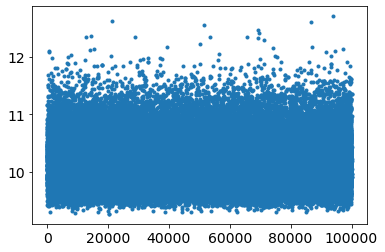

In [18]:
plt.plot(2*p_samples1[:,0]/len(qi1), '.')

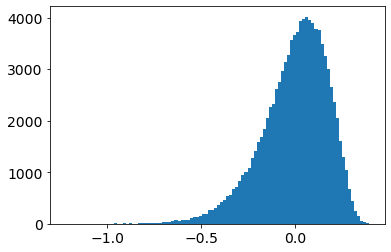

In [19]:
plt.hist(p_samples1[:,1], bins=100);
# plt.xlim(-np.mean(p_samples1[:,0]), np.mean(p_samples1[:,0]))

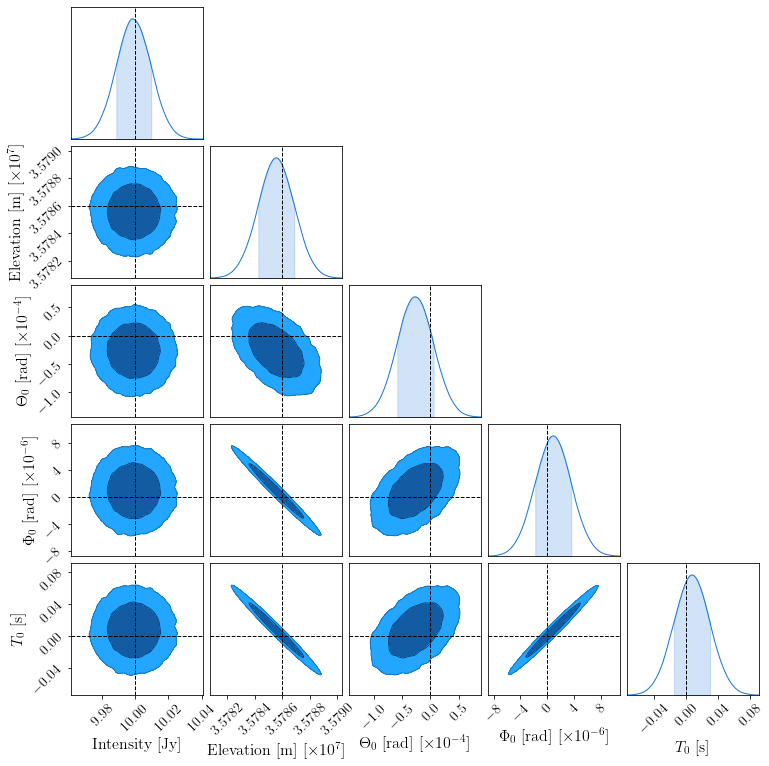

In [20]:
c = ChainConsumer()
param_names = ['Intensity [Jy]', 'Elevation [m]', '$\Theta_0$ [rad]', '$\Phi_0$ [rad]', '$T_0$ [s]']
true_val = [obs1.rfi_I[0,0], obs1.rfi_elevation[0], obs1.rfi_theta0[0], obs1.rfi_phi0[0], obs1.rfi_t0[0]]
c.add_chain(samples1[:,:5], parameters=param_names)
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/RFI_P1.pdf", figsize=1.5, truth=true_val)

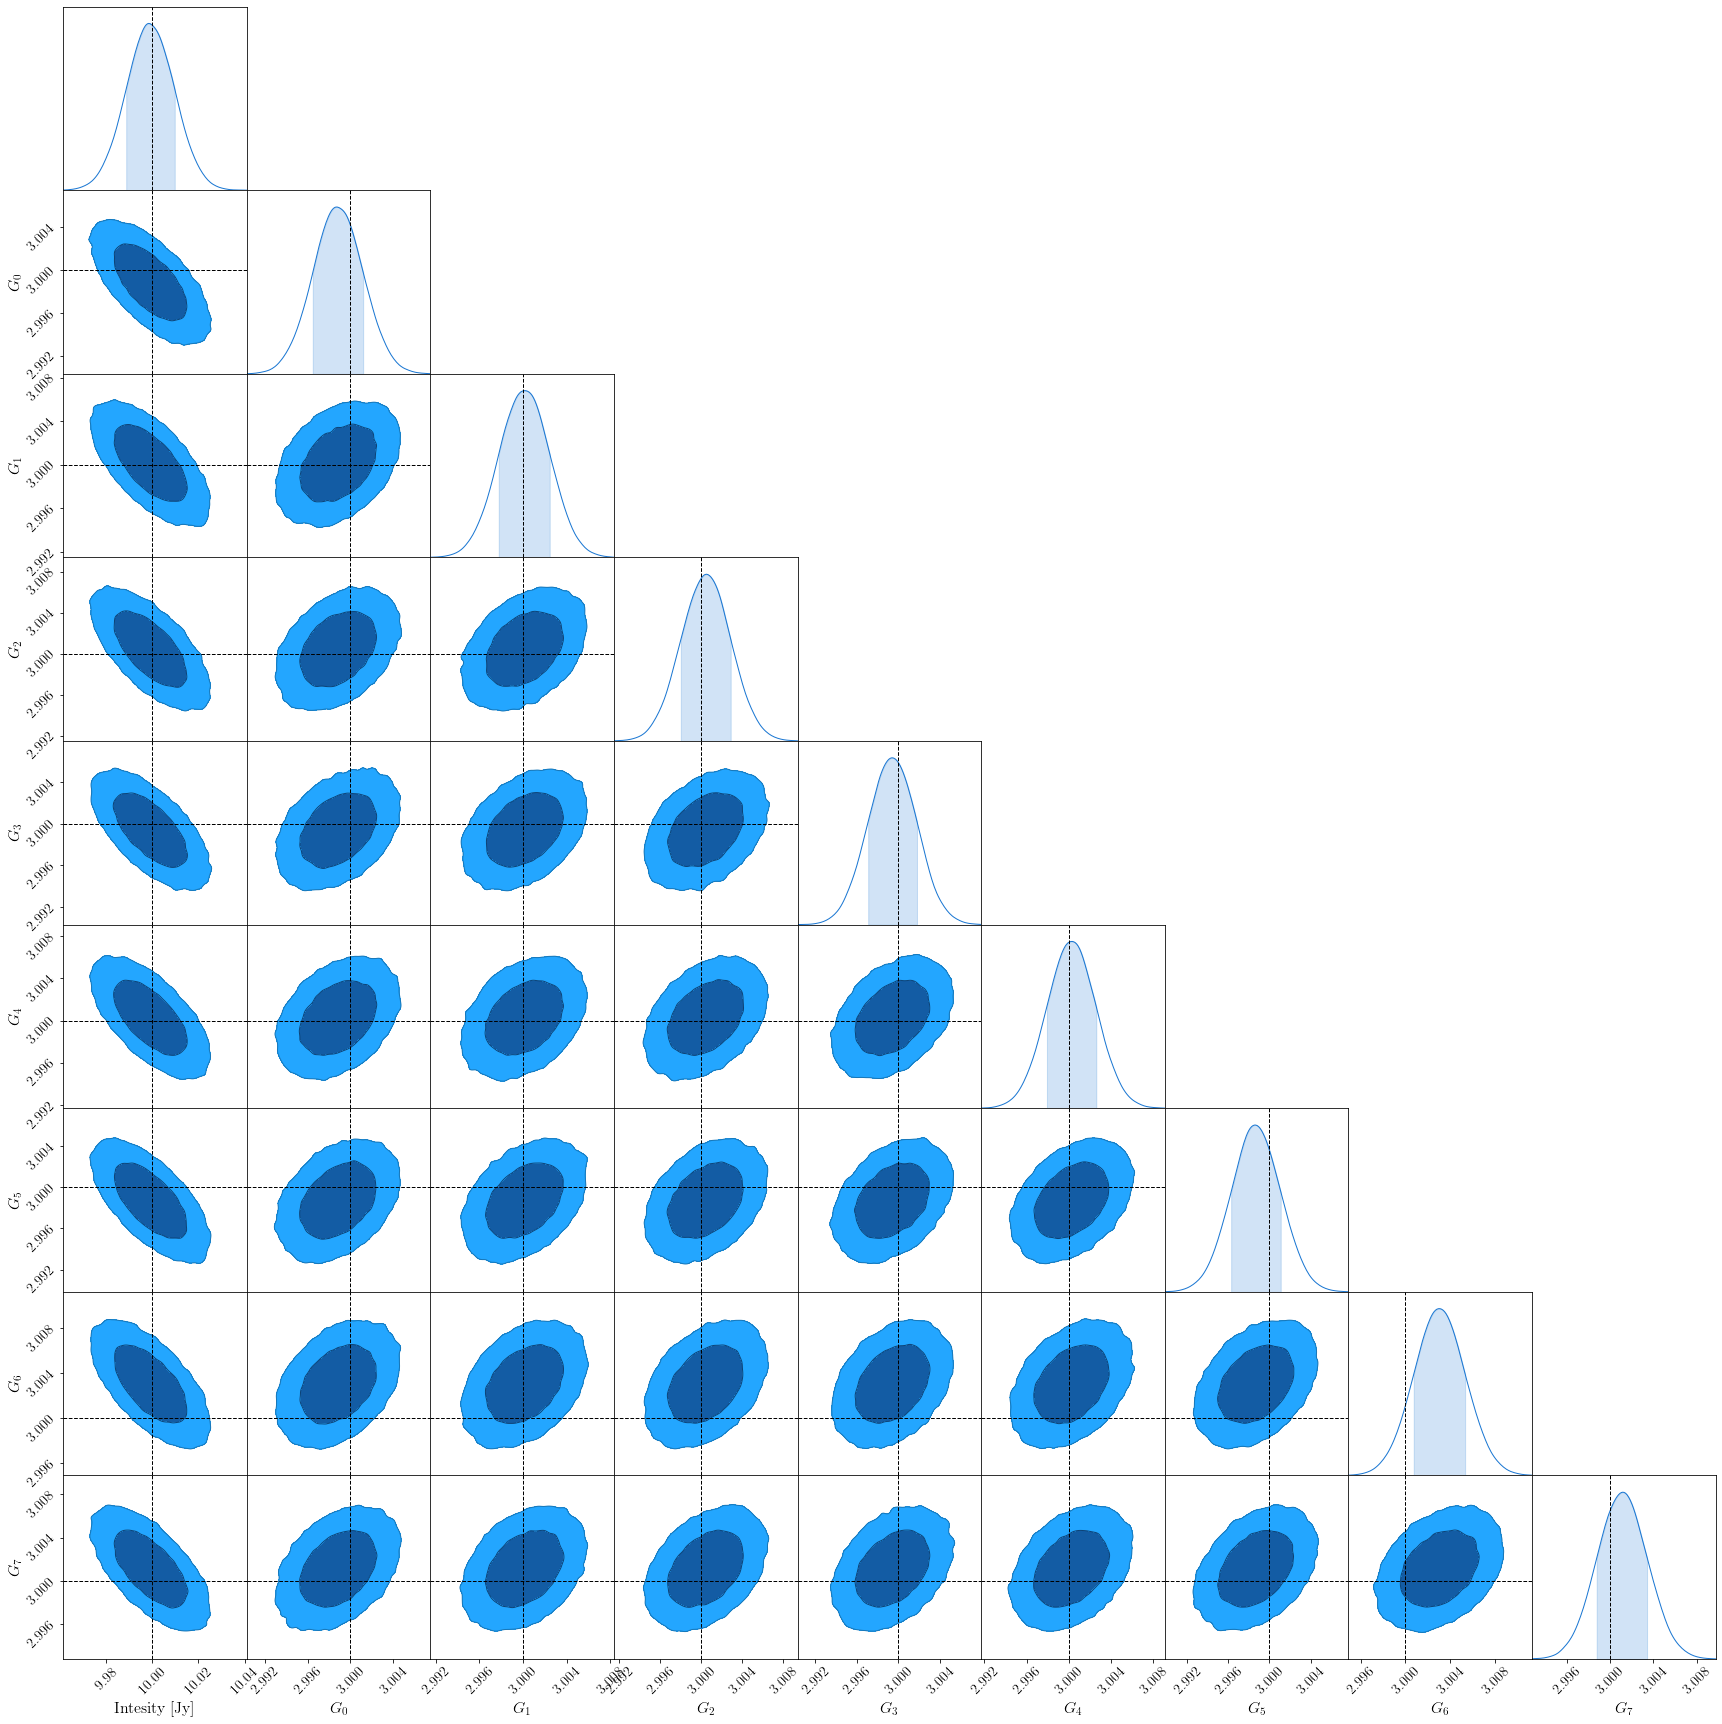

In [21]:
c = ChainConsumer()
param_names = ['Intesity [Jy]',] + [f'$G_{i}$' for i in range(obs1.n_ants)]
true_val = [obs1.rfi_I[0,0],] + list(obs1.gains_ants[0,:,0])
c.add_chain(samples1[:,[0,5,6,7,8,9,10,11,12]], parameters=param_names)
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/Gains_P1.pdf", figsize=2., truth=true_val)

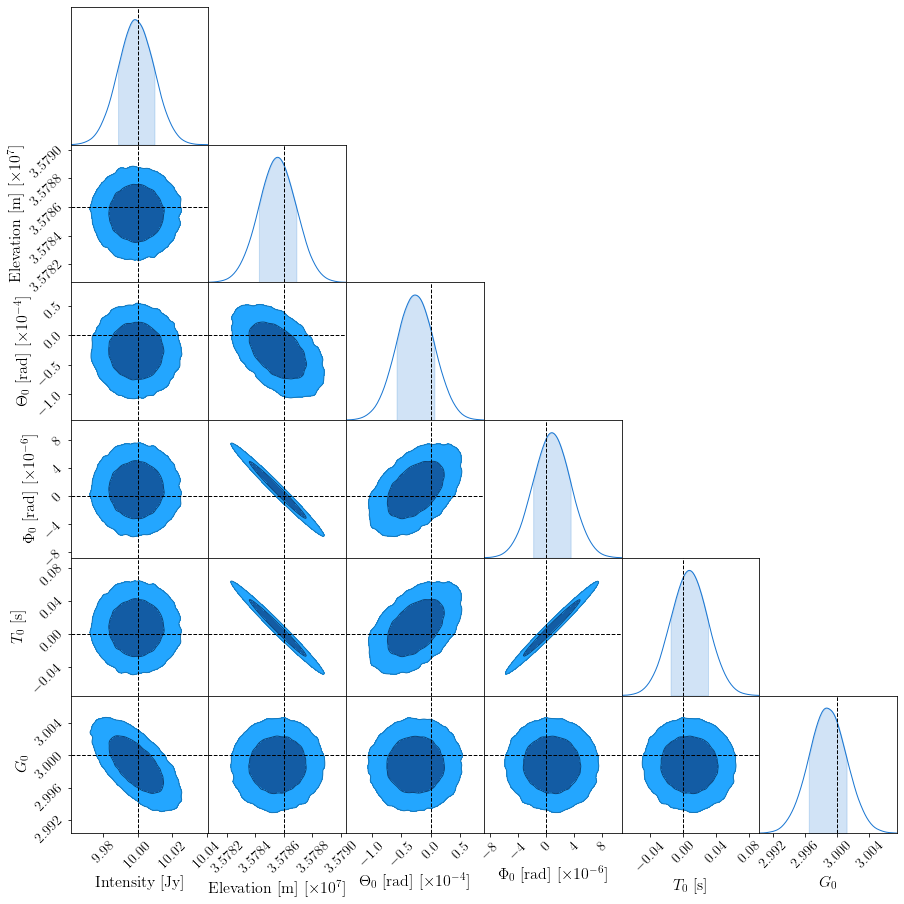

In [22]:
c = ChainConsumer()
param_names = ['Intensity [Jy]', 'Elevation [m]', '$\Theta_0$ [rad]', 
               '$\Phi_0$ [rad]', '$T_0$ [s]', '$G_0$']
true_val = [obs1.rfi_I[0,0], obs1.rfi_elevation[0], obs1.rfi_theta0[0], 
            obs1.rfi_phi0[0], obs1.rfi_t0[0], obs1.gains_ants[0,0,0]]
c.add_chain(samples1[:,:6], parameters=param_names)
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/RFI_G0_P1.pdf", figsize=1.5, truth=true_val)

In [23]:
obs1.n_bl, obs1.n_ants

(28, 8)

In [24]:
@jit
def log_prior2(q, params):
    
#     PARAMETERS
    mu_rfi_g = params['mu_rfi_g']
    inv_cov_rfi_g = params['inv_cov_rfi_g']
    n_ants = params['n_ants']
    
    lp = log_multinorm(jnp.concatenate([q[:5],q[-obs2.n_ants:]]), mu_rfi_g, inv_cov_rfi_g)
    
#     lp = log_multinorm(jnp.concatenate([q[:5],G_[0]]), mu_rfi_g, inv_cov_rfi_g) + \
#                 np.sum(log_normal(V_ast_1_-V_ast_2_, 0., 1.))

    return lp

@jit
def log_likelihood2(q, params):
    
#     PARAMETERS
    correction = params['phase_corrections']
    noise = params['noise']
    ants_xyz = params['ants_xyz']
    freqs = params['freqs']
    n_bl = params['n_bl']
    n_ants = params['n_ants']
    t = params['times']
    tempering = params['tempering']
    
    N_ant = obs1.n_ants
    N_blx2 = N_ant*(N_ant-1)
    
#     THETA
    A, el, theta0, phi0, t0 = q[:5]
    V_ast_ = jnp.concatenate([q[5+i*N_blx2:5+(i+1)*N_blx2][None,:] for i in range(len(t))], axis=0)
    G_ = q[-N_ant:][None,:]
    
#     DATA
    V_obs_ = params['D']
    
#     Calculate the visibility contribution from the RFI
    rfi_xyz = orbit(t, el, theta0, phi0, t0)
    distances = jnp.linalg.norm(ants_xyz-rfi_xyz[:,None,:], axis=2)
    V_rfi_ = rfi_vis(A*jnp.ones((1,1)), (distances-correction)[...,None], freqs)[...,0]
    
    G_bl_ = ants_to_bl(G_)[0]
    
#     log_likelihood
    model_vis = jnp.concatenate([G_bl_*(V_ast_[i]+V_rfi_[i]) for i in range(len(t))])
    
    return tempering*np.sum(log_normal(model_vis, V_obs_, noise)) 

In [25]:
@jit
def U2(q, params):

    return -(log_prior2(q, params) + log_likelihood2(q, params))

In [26]:
delU2 = jit(grad(U2, 0))

def NLL2(q):
        return U2(q, params2)
def inv_cov2():
    return jit(jacfwd(jacrev(NLL2)))

In [27]:
obs2 = Observation(latitude=obs1.latitude, longitude=obs1.longitude, elevation=obs1.elevation, ra=obs1.ra, 
                   dec=obs1.dec, times=8.*np.arange(len(obs1.times), len(obs1.times)+2), 
                   freqs=obs1.freqs, ENU_array=obs1.ENU)

obs2.addAstro(I=0.1*np.ones((1,100)), ra=20.5+np.random.rand(100), dec=-30.5+np.random.rand(100))

obs2.addSat(I=obs1.rfi_I, elevation=obs1.rfi_elevation[0], t0=obs1.rfi_t0[0], 
            theta0=obs1.rfi_theta0[0], phi0=obs1.rfi_phi0[0])

obs2.addGains(G0_mean=obs1.gains_ants[0,0,0], G0_std=0., Gt_mean=0., Gt_std=0.)

obs2.addNoise(noise=0.2)

In [28]:
qi2 = np.concatenate([obs2.rfi_I[:,0], obs2.rfi_elevation, obs2.rfi_theta0, 
                      obs2.rfi_phi0, obs2.rfi_t0, *[obs2.vis_ast[i,:,0] for i in range(len(obs2.times))], 
                      obs2.gains_ants[0,:,0]])

# qi2 = np.concatenate([np.mean(rfi_samples1, axis=0), obs2.vis_ast[0,:,0], obs2.vis_ast[1,:,0], 
#                       np.mean(g_samples1, axis=0)])

In [29]:
params2 = {}
params2['freqs'] = obs2.freqs
params2['times'] = obs2.times
params2['noise'] = 0.2 # obs2.noise
params2['ants_xyz'] = obs2.ants_xyz
params2['phase_corrections'] = obs2.ants_uvw[...,-1]
params2['n_ants'] = obs2.n_ants
params2['n_bl'] = obs2.n_bl
# params2['mu_rfi_g'] = np.mean(np.concatenate([rfi_samples1, g_samples1], axis=1), axis=0)
params2['mu_rfi_g'] = np.concatenate([obs2.rfi_I[0], obs2.rfi_elevation, obs2.rfi_theta0, 
                                      obs2.rfi_phi0, obs2.rfi_t0, obs2.gains_ants[0,:,0]])
params2['inv_cov_rfi_g'] = np.linalg.inv(np.cov(np.concatenate([rfi_samples1, g_samples1], axis=1).T))
params2['D'] = np.concatenate([obs2.vis[i,:,0] for i in range(len(obs2.times))])
params2['tempering'] = 1e0

In [30]:
U2(qi2, params2)

DeviceArray(66.46979084, dtype=float64)

In [31]:
icov2 = inv_cov2()(qi2)

In [32]:
# cov2 = np.linalg.inv(icov2)
cov_rfi2 = np.linalg.inv(icov2[:5,:5])
cov_vis2 = np.linalg.inv(icov2[5:5+2*obs2.n_bl*len(obs2.times),5:5+2*obs2.n_bl*len(obs2.times)])
cov_g2 = np.linalg.inv(icov2[-obs1.n_ants:,-obs1.n_ants:])

In [33]:
M_inv2 = block_diag(cov_rfi2, cov_vis2, cov_g2)
M2 = np.linalg.inv(M_inv2)
L2 = np.linalg.cholesky(M2)

In [34]:
try:
    samples2 = np.load('samples2_8_new.npy')
except:
    s = time.time()
    samples2 = HMC(U2, delU2, qi2, params2, M_inv2, L2, delta_t=3.5e-1, T=10, n_samples=100000, key=key)
    print('Time taken {}s'.format(time.time()-s))
    
rfi_samples2 = samples2[:,:5]
vis_samples2 = samples2[:,5:5+2*obs2.n_bl*obs2.n_time]
g_samples2 = samples2[:,5+2*obs2.n_bl*obs2.n_time:-3]
p_samples2 = samples2[:,-3:]
nll_samples2 = -vmap(log_likelihood2, in_axes=(0, None))(samples2[:,:-3], params2)
nlp_samples2 = -vmap(log_prior2, in_axes=(0, None))(samples2[:,:-3], params2)

100%|██████████| 99999/99999 [03:12<00:00, 519.94it/s]


Time taken 204.98031735420227s


In [35]:
start_idx = 0
end_idx = None
print('Acceptance Ratio : {} %'.format(round(100*np.sum(p_samples2[:,-1])/len(p_samples2), 2)))

Acceptance Ratio : 86.83 %


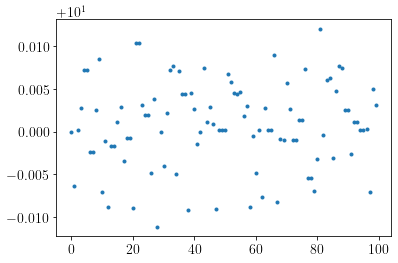

In [36]:
plt.plot(rfi_samples2[:100,0], '.')

Text(0, 0.5, 'Energy')

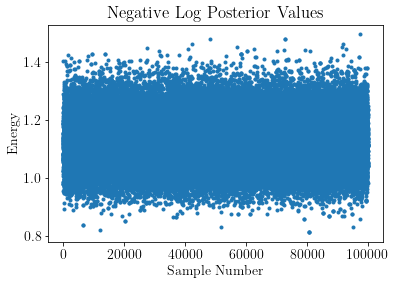

In [37]:
plt.figure()
# plt.semilogy(p_samples2[:,0], '.', alpha=1)
plt.plot(2*p_samples2[:,0]/len(qi2), '.', alpha=1)
plt.title('Negative Log Posterior Values')
plt.xlabel('Sample Number')
plt.ylabel('Energy')

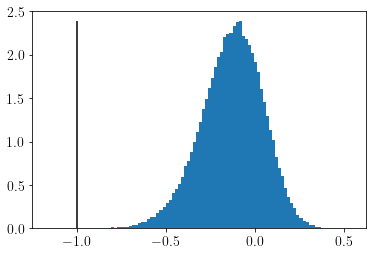

In [38]:
fig = plt.figure()
ax = fig.subplots(1)
counts = ax.hist(p_samples2[:,1], bins=100, density=True)
ax.vlines(-1, 0, counts[0].max(), 'k')
# plotNorm(ax, np.mean(p_samples2[:,1]), np.std(p_samples2[:,1]))
# np.mean(p_samples2[:,1]), np.std(p_samples2[:,1])

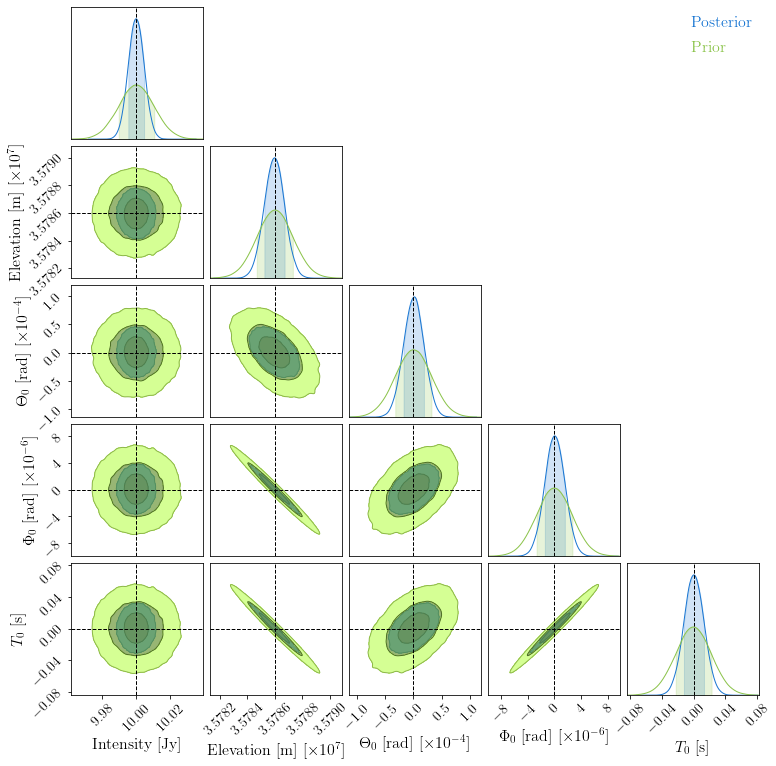

In [39]:
c = ChainConsumer()
param_names = ['Intensity [Jy]', 'Elevation [m]', '$\Theta_0$ [rad]', '$\Phi_0$ [rad]', '$T_0$ [s]']
true_val = [obs2.rfi_I[0,0], obs2.rfi_elevation[0], obs2.rfi_theta0[0], obs2.rfi_phi0[0], obs2.rfi_t0[0]]
c.add_chain(samples2[:,:5], parameters=param_names, name='Posterior')
PriorL = np.linalg.cholesky(np.cov(samples1[:,:5].T))
PriorSamples = np.dot(PriorL, np.random.randn(5, 100000)).T + params2['mu_rfi_g'][None,:5]
c.add_chain(PriorSamples, parameters=param_names, name='Prior')
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/RFI_P2.pdf", figsize=1.5, truth=true_val)

In [40]:
c = ChainConsumer()
param_names = ['Intensity [Jy]', 'Elevation [m]', '$\Theta_0$ [rad]', '$\Phi_0$ [rad]', '$T_0$ [s]']
c.add_chain(np.array(rfi_samples2), parameters=param_names, walkers=4)
c.diagnostic.gelman_rubin()

Gelman-Rubin Statistic values for chain Chain 0
Intensity [Jy]: 1.00000 (Passed)
Elevation [m]: 1.00006 (Passed)
$\Theta_0$ [rad]: 0.99999 (Passed)
$\Phi_0$ [rad]: 1.00006 (Passed)
$T_0$ [s]: 1.00006 (Passed)


True

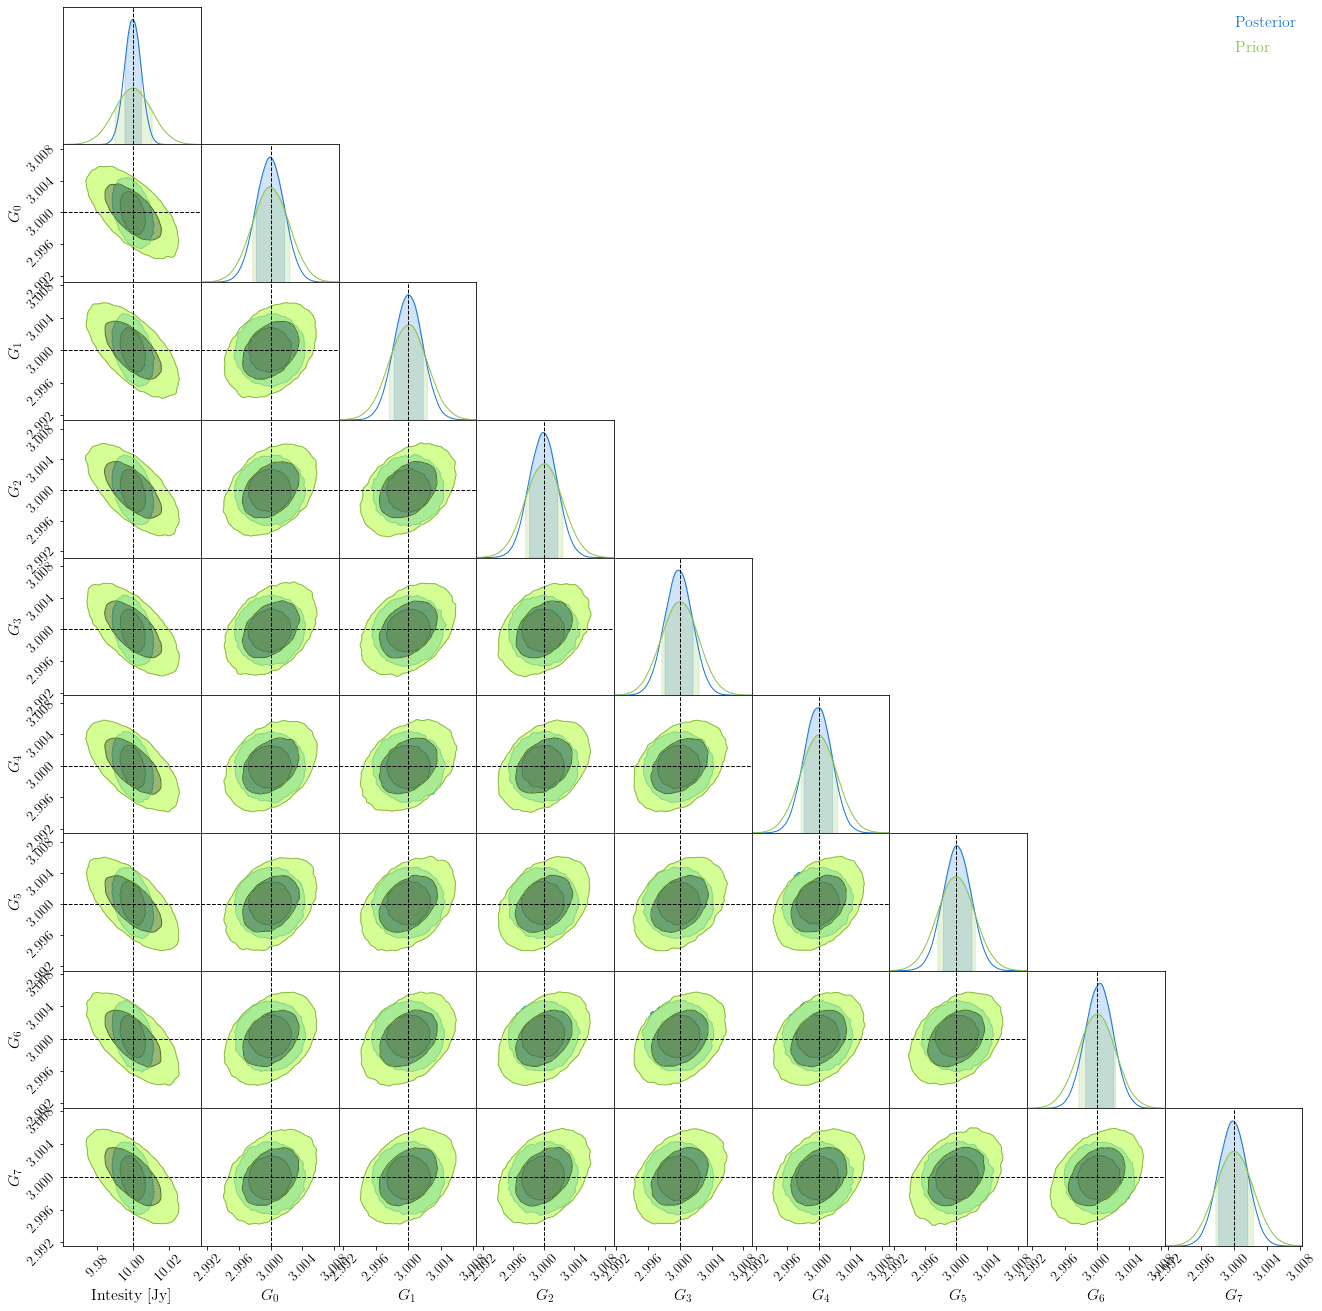

In [41]:
c = ChainConsumer()
param_names = ['Intesity [Jy]',] + [f'$G_{i}$' for i in range(obs1.n_ants)]
true_val = [obs2.rfi_I[0,0],] + list(obs2.gains_ants[0,:,0])
param_idx = [0,] + list(np.arange(obs1.n_ants)+5+len(vis_samples2.T))
c.add_chain(samples2[:,param_idx], parameters=param_names, name='Posterior')
PriorL = np.linalg.cholesky(np.cov(samples1[:,:5+obs1.n_ants].T))
PriorSamples = np.dot(PriorL, np.random.randn(5+obs1.n_ants, 100000)).T + params2['mu_rfi_g'][None,:]
c.add_chain(PriorSamples[:,[0,5,6,7,8,9,10,11,12]], parameters=param_names, name='Prior')
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/RFI_G_P2.pdf", figsize=1.5, truth=true_val)

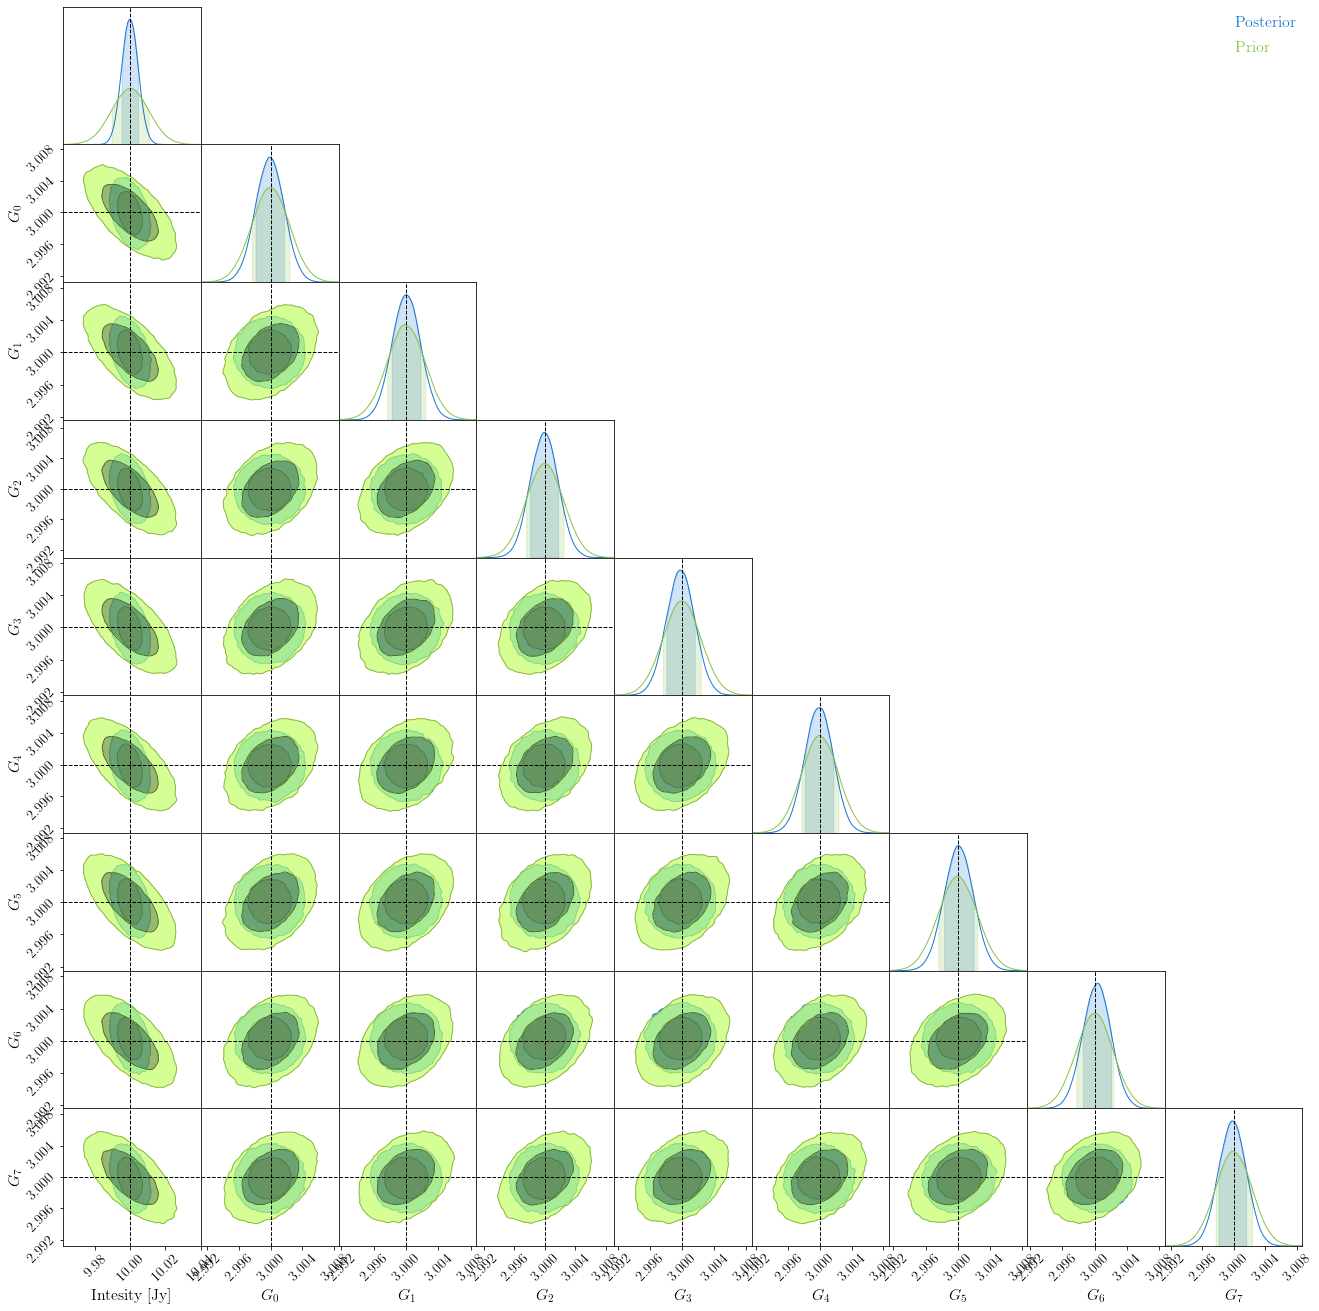

In [42]:
c = ChainConsumer()
param_names = ['Intesity [Jy]',] + [f'$G_{i}$' for i in range(obs1.n_ants)]
true_val = [obs2.rfi_I[0,0],] + list(obs2.gains_ants[0,:,0])
param_idx = [0,] + list(np.arange(obs1.n_ants)+5+len(vis_samples2.T))
c.add_chain(samples2[:,param_idx], parameters=param_names, name='Posterior')
PriorL = np.linalg.cholesky(np.cov(samples1[:,:5+obs1.n_ants].T))
PriorSamples = np.dot(PriorL, np.random.randn(5+obs1.n_ants, 100000)).T + params2['mu_rfi_g'][None,:]
c.add_chain(PriorSamples[:,[0,5,6,7,8,9,10,11,12]], parameters=param_names, name='Prior')
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/Gains_P2.pdf", figsize=1.5, truth=true_val)

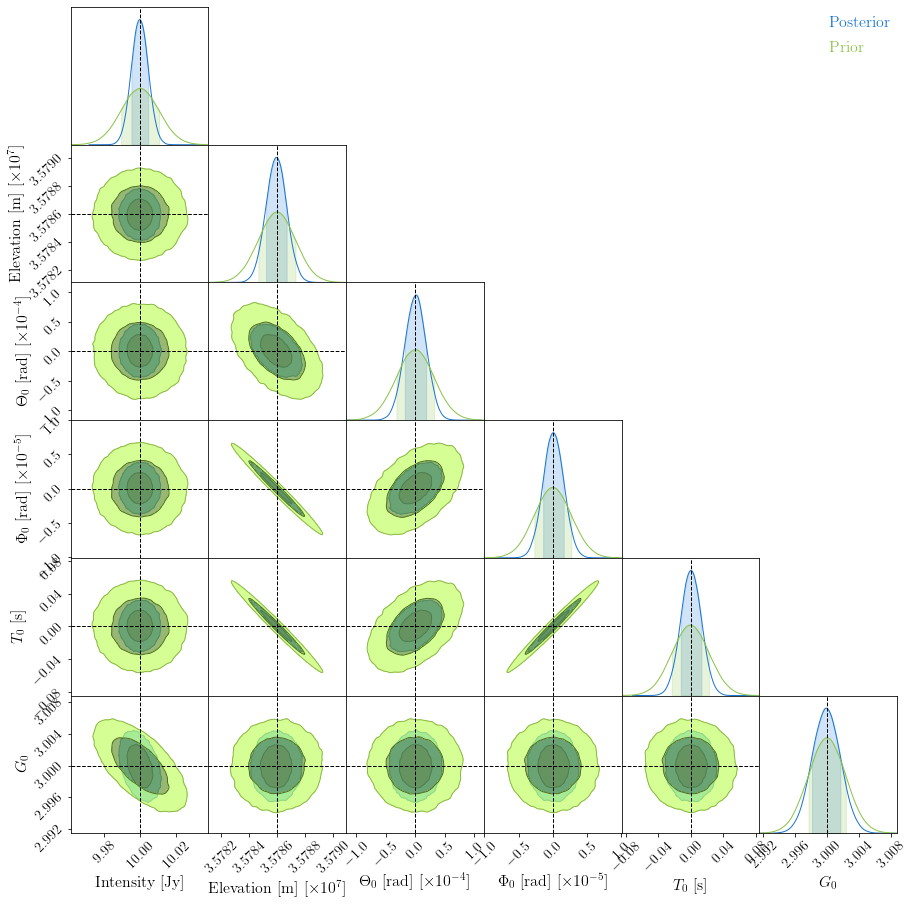

In [43]:
c = ChainConsumer()
param_names = ['Intensity [Jy]', 'Elevation [m]', '$\Theta_0$ [rad]', 
               '$\Phi_0$ [rad]', '$T_0$ [s]', '$G_0$']
true_val = [obs2.rfi_I[0,0], obs2.rfi_elevation[0], obs2.rfi_theta0[0], 
            obs2.rfi_phi0[0], obs2.rfi_t0[0], obs2.gains_ants[0,0,0]]
c.add_chain(samples2[:,[0,1,2,3,4,5+2*obs2.n_bl*obs2.n_time]], parameters=param_names, name='Posterior')
PriorL = np.linalg.cholesky(np.cov(samples1[:,:5+obs1.n_ants].T))
PriorSamples = np.dot(PriorL, np.random.randn(5+obs1.n_ants, 100000)).T + params2['mu_rfi_g'][None,:]
c.add_chain(PriorSamples[:,:6], parameters=param_names, name='Prior')
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/RFI_G0_P2.pdf", figsize=1.5, truth=true_val)

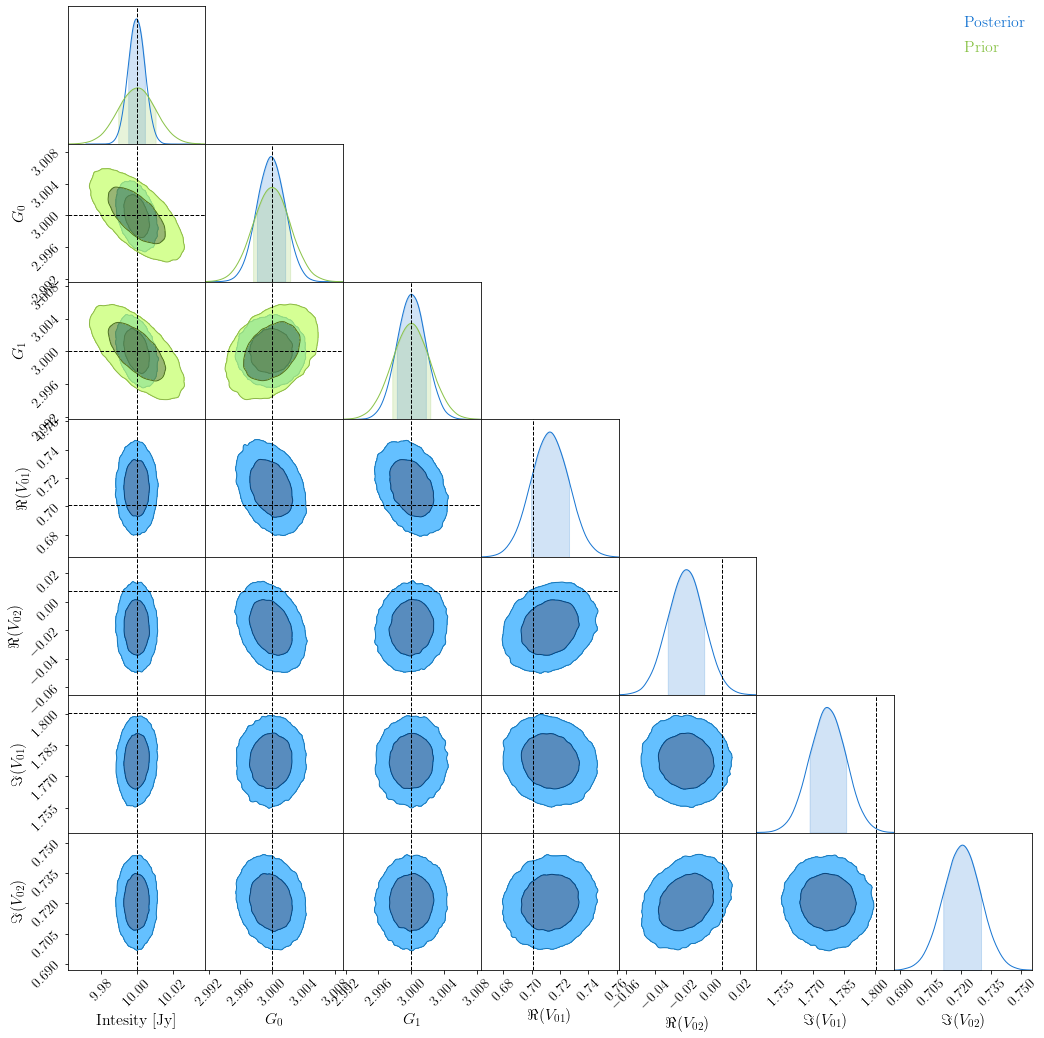

In [44]:
c = ChainConsumer()
param_names = ['Intesity [Jy]', '$G_0$', '$G_1$', '$\Re(V_{01})$', '$\Re(V_{02})$', 
               '$\Im(V_{01})$', '$\Im(V_{02})$']
true_val = [obs2.rfi_I[0,0],] + list(obs2.gains_ants[0,:2,0]) + \
           list(obs2.vis_ast[0,:2,0]) + list(obs2.vis_ast[0,obs2.n_bl:obs2.n_bl+2,0])
param_idx = [0, 5+2*obs2.n_bl*obs2.n_time, 6+2*obs2.n_bl*obs2.n_time, 5, 6, 5+obs2.n_bl, 6+obs2.n_bl]
c.add_chain(samples2[:,param_idx], parameters=param_names, name='Posterior')
PriorL = np.linalg.cholesky(np.cov(samples1[:,:5+obs1.n_ants].T))
PriorSamples = np.dot(PriorL, np.random.randn(5+obs1.n_ants, 100000)).T + params2['mu_rfi_g'][None,:]
c.add_chain(PriorSamples[:,[0,5,6]], parameters=param_names[:3], name='Prior')
c.configure(diagonal_tick_labels=True, tick_font_size=14, label_font_size=16, max_ticks=5)
fig = c.plotter.plot(filename="../plots/RFI_I_G_Vis_P2.pdf", figsize=1.5, truth=true_val)

In [45]:
obs2.vis_ast[0,obs2.n_bl:obs2.n_bl+2,0]

DeviceArray([1.80028275, 0.75829258], dtype=float64)

In [47]:
post_mean = np.mean(samples2[:,:-3], axis=0)

print('Posterior Mean values')
nlpost = U2(post_mean, params2)
nll = -log_likelihood2(post_mean, params2)
nlp = -log_prior2(post_mean, params2)
print(f'NL Likelihood : {nll}\nNL Prior : \t{nlp}\nNL Posterior : \t{nlpost}')

print('\nTrue Values')
nlpost = U2(qi2, params2)
nll = -log_likelihood2(qi2, params2)
nlp = -log_prior2(qi2, params2)
print(f'NL Likelihood : {nll}\nNL Prior : \t{nlp}\nNL Posterior : \t{nlpost}')

Posterior Mean values
NL Likelihood : 54.572300447835396
NL Prior : 	0.03531425372888631
NL Posterior : 	54.60761470156428

True Values
NL Likelihood : 66.46979084488795
NL Prior : 	0.0
NL Posterior : 	66.46979084488795
